In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import softmax
import json 
import torch

In [2]:
cd ../pytorch

/Users/trentonbricken/protein-gen/pytorch


In [3]:
from metropolis import MetropolisHastings
from utils import *
from EVCouplingsGen import *
from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

In [4]:
params = {'protein_length':2}
# Loading in EVCouplings model 
focus_seqs = read_fa('EVCouplingsStuff/DYR_ECOLI_1_b0.5.a2m_trimmed.fa')
evc_model = CouplingsModel('EVCouplingsStuff/DYR.model')

# extracting the model parameters used to determine the evolutionary hamiltonian
h = evc_model.h_i
J = evc_model.J_ij

if params['protein_length'] > 0:
    h = h[0:params['protein_length'], :]
    J = J[0:params['protein_length'], 0:params['protein_length'], :,:]

# processing and plotting the natural sequences: 
# first by converting amino acids into integers and also onehots. 
enc_seqs=[]
oh = []
AA=h.shape[1] # number of amino acids
for seq in focus_seqs['seq']:
    enc_seq = np.asarray(encode_aa(seq, evc_model.alphabet_map))
    if params['protein_length'] > 0: 
        enc_seq = enc_seq[:params['protein_length']]
    enc_seqs.append(enc_seq) 
    oh.append(onehot(enc_seq,AA)) # this could be made much more efficient with tensorflow operations. 
enc_seqs = np.asarray(enc_seqs)
oh=np.asarray(oh) # of shape: [batch x L x AA]
N = oh.shape[0] # batch size
L = oh.shape[1] # length of the protein

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# loading in the environment class, used to score the evolutionary hamiltonians
gen_model = EVCouplingsGenerator(L, AA, h, J, device, False, gaussian_cov_noise = 1.0)


shape of feature map torch.Size([20, 3])


In [12]:
nsteps = 3000
sampler = MetropolisHastings(gen_model, noise=5.0, 
                     stride=5, mapper=None, 
                     is_discrete=True, AA_num=AA)
#mapper=HardMaxMapper() but now I have discrete actions so dont need. 
sample_x = sampler.run(nsteps)

In [13]:
sample_x.shape

(38400, 40)

In [14]:
def hard_max(inp):
    if inp.shape[1] > L: # if it isnt a sequence of ints, then all to one hot.  
        #print('the input to oh is', inp)

        if len(inp)>2:
            inp = inp.reshape(inp.shape[0], -1, 20)
        else:
            inp = inp.reshape(-1,20)

        inp = np.argmax(inp, axis=-1)
    return inp

def seq_counter(seqs, AA=20):
    # assumes not in one hot
    counter = np.zeros((AA, AA))
    for s in seqs: 
        counter[s[0], s[1]] +=1
    return counter

In [15]:
x = hard_max(sample_x)
print('sample x shape', sample_x.shape, 'hard max', x.shape)
counter = seq_counter(x)

sample x shape (38400, 40) hard max (38400, 2)


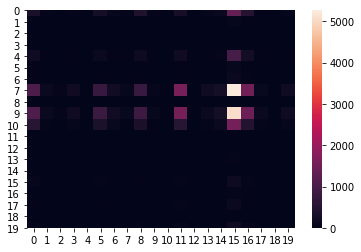

In [16]:
import seaborn as sns;
%matplotlib inline
sns.heatmap(counter.T)